## Imports

In [37]:
!pip install --quiet gcsfs pandas pyarrow seaborn pillow tqdm open_clip_torch faiss-cpu

In [39]:
%pip install --quiet --upgrade "numpy<2" --force-reinstall

  You can safely remove it manually.
Note: you may need to restart the kernel to use updated packages.


In [23]:
from google.cloud import bigquery
import google.api_core.exceptions as gexc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from IPython.display import display
import textwrap, random, os
from tqdm import tqdm
plt.style.use("default") 
import numpy as np

import fsspec                      
import gcsfs                       
from io import BytesIO

import torch, faiss, json, math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import open_clip

from scipy import stats                    # for bootstrap CIs
from typing import List, Dict, Tuple



## Query Data

In [9]:
# Initialize BigQuery client (uses default project)
bq_client = bigquery.Client()          
print("BigQuery project:", bq_client.project)

BigQuery project: data-science-pro-1dedbf8f


In [10]:
# SQL query to fetch PREDICT samples
SQL = """
SELECT
  dataset.*
FROM  `backend-producti-b8633498.prod_silver_intermediate.int_logged_meal_eval_dataset`   AS dataset
JOIN  `backend-producti-b8633498.prod_silver_intermediate.int_offline_eval_samples`       AS samples
  ON  dataset.image_filename = samples.image_filename
WHERE samples.dataset_type = "PREDICT"
LIMIT 1000
"""

job = bq_client.query(SQL)

try:
    # --- Fast path: BigQuery Storage API ---
    df = job.result().to_dataframe(create_bqstorage_client=True)
    print("Downloaded via BigQuery Storage API 🚀")
except gexc.PermissionDenied:
    # --- Fallback: classic REST API ---
    print("No Storage-API permission – falling back to Tabledata API (slower)…")
    df = job.result().to_dataframe(create_bqstorage_client=False)

print(f"\nLoaded {len(df):,} rows • {df.shape[1]} columns")
display(df.head())

No Storage-API permission – falling back to Tabledata API (slower)…

Loaded 1,000 rows • 33 columns


,created_at,start_at,username,zmeal_id,dish_id,serving_id,food_id,food_name,meal_type,study,...,caffeine,brand_name,processed_category_name,generic_food_score,master_category_name,parent_name,reference_product_parent_id,food_tree_level_1,food_tree_level_2,food_tree_level_3
0,2019-12-07 15:26:04.479000+00:00,2019-12-07 15:26:58+00:00,predict2_000717,None,32767f43-d91a-4850-a5ea-255dcf82a5b9,10bdb952-844e-40f4-a2a5-9ca807919ccc,63d0f192-174a-4483-ab43-3f4c60017cb7,Nutiva Hemp Protein Organic Superfood,f,PREDICT US 2.0,...,None,Nutiva,Ultra-processed,49.531895,Nutritional Supplements,PROTEIN POWDER,67f4241f-b560-42a6-ac1e-1ab12c2818ba,"Sugars, Sweets, and Beverages","Formulated nutrition beverages, energy drinks,...",Protein and nutritional powders
1,2019-11-17 13:19:55.506000+00:00,2019-11-17 13:18:47+00:00,predict2_000393,None,0d86fc3c-aeba-4809-b138-efe8ae00fd79,03477ed7-b8b3-480b-92ee-8699e5e49493,7b09da82-4266-4120-9ba3-d6bd825e1d5c,Stevia In The Raw Zero Calorie Sweetener,f,PREDICT US 2.0,...,None,Stevia In The Raw,Ultra-processed,29.490885,Sweeteners,TABLETOP SWEETENERS,c6b4d19e-2aa3-4388-af37-9852f5e46132,"Sugars, Sweets, and Beverages","Sugars, sweets",Sugar substitutes
2,2020-02-23 22:32:18.562000+00:00,2020-02-23 22:25:09+00:00,predict2_000853,None,fa38dcb6-93b4-4175-b7e8-212b01d666ef,d4d5a353-bf36-4466-9b95-40b13c5b7824,d68fe1ac-92b0-4a98-abd5-257e5aee4a40,Giant Nature's Promise Tomato Ketchup,f,PREDICT US 2.0,...,None,Giant Nature's Promise,Ultra-processed,0.000000,Dipping sauces,KETCHUP,9fcfa6f1-9549-461a-886f-075844a91a98,Vegetables,"Tomatoes, tomato mixtures",Ketchup
3,2020-02-15 02:21:38.886000+00:00,2020-02-15 02:40:00+00:00,predict2_000851,None,b9cc4698-0482-4ba3-aee2-fa4454ce87f0,0d2bcbd4-ba34-490c-b509-427180dcda31,d5ca9b74-0341-43e7-9017-360f5d67e22b,"Northwest Finest Organic Ground Beef, 85/15",d,PREDICT US 2.0,...,None,Northwest Finest,Processed,32.097904,Beef,BEEF MINCE,f96a86c3-56ef-4cd1-965b-d1d5f0d3f8e8,"Meat, Poultry, Fish and Mixtures",Beef,"Beef (e.g. roast beef, steak, ribs)"
4,2019-09-18 04:50:05.805000+00:00,2019-09-18 04:44:37+00:00,predict2_000199,None,a5b610ed-98c4-4635-a215-ab87517073d0,6b40f805-8054-4382-9b6a-cce48c8a85d3,c566ce86-135e-42da-a559-6657fbcd4af7,"Chillycow Light Ice Cream, Peanut Butter",s,PREDICT US 2.0,...,None,Chillycow,Ultra-processed,37.846199,Ice cream,ICE CREAM,240cb1bd-1910-4364-8464-91e1fb96ade2,Milk and Milk Products,Milk desserts and sauces,Ice cream and frozen dairy desserts


In [11]:
# Cache to Parquet to avoid repeated pulls
CACHE = Path("bq_cache.parquet")
if not CACHE.exists():
    df.to_parquet(CACHE, index=False)
    print("Cached to", CACHE)
else:
    print("Cache already present 🚀 – delete the file if you need a fresh pull")

Cached to bq_cache.parquet


## Exploration

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   created_at                   1000 non-null   datetime64[us, UTC]
 1   start_at                     1000 non-null   datetime64[us, UTC]
 2   username                     1000 non-null   object             
 3   zmeal_id                     508 non-null    object             
 4   dish_id                      1000 non-null   object             
 5   serving_id                   1000 non-null   object             
 6   food_id                      1000 non-null   object             
 7   food_name                    1000 non-null   object             
 8   meal_type                    1000 non-null   object             
 9   study                        1000 non-null   object             
 10  country                      1000 non-null   obje

,calories,fat,carbohydrate,sugar,fibre,protein,sodium,quantity
count,1000.000000,1000.000000,1000.000000,999.000000,996.000000,1000.000000,1000.000000,1000.000000
mean,75.246086,3.592616,6.766119,2.549164,1.020678,3.185806,0.099484,84.363716
std,100.180000,6.544053,13.115891,5.528412,1.810441,5.936656,0.203856,117.024742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
25%,6.923908,0.013965,0.088230,0.000000,0.000000,0.087000,0.000560,17.000000
50%,32.757896,0.307500,1.278998,0.495000,0.196078,0.700000,0.008680,44.049999
75%,112.094826,4.554542,6.228000,2.274000,1.252179,3.410250,0.109305,100.730543
99%,434.845869,30.955473,68.022000,25.255291,8.285580,28.008488,0.898636,500.180000
max,680.000000,43.160000,135.383331,73.566956,18.005983,53.956001,2.016949,1500.000000


/var/tmp/ipykernel_12542/4231936720.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


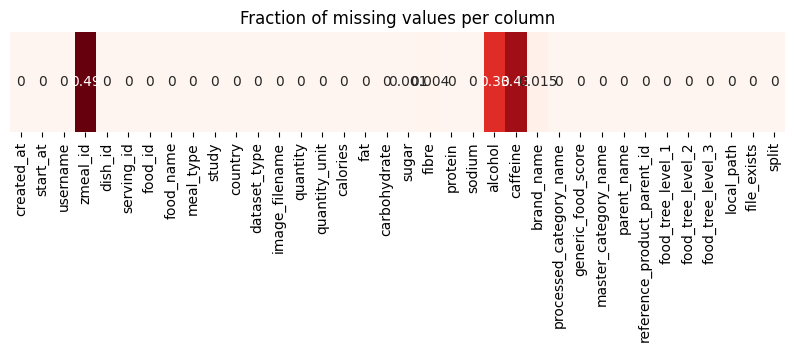

In [29]:

df.info()

# Convert nutrition columns to numeric if needed (they may be strings with '0E-9' etc.)
num_cols = [
    "calories", "fat", "carbohydrate", "sugar",
    "fibre", "protein", "sodium", "quantity"
]

for col in NUM_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce").astype("float32")



display(df[num_cols].describe(percentiles=[.01, .25, .5, .75, .99]))

# Plot fraction of missing values per column
plt.figure(figsize=(10, 1.3))
sns.heatmap(df.isna().mean().to_frame().T, cmap="Reds", cbar=False, annot=True)
plt.title("Fraction of missing values per column")
plt.yticks([])
plt.tight_layout()
plt.show()

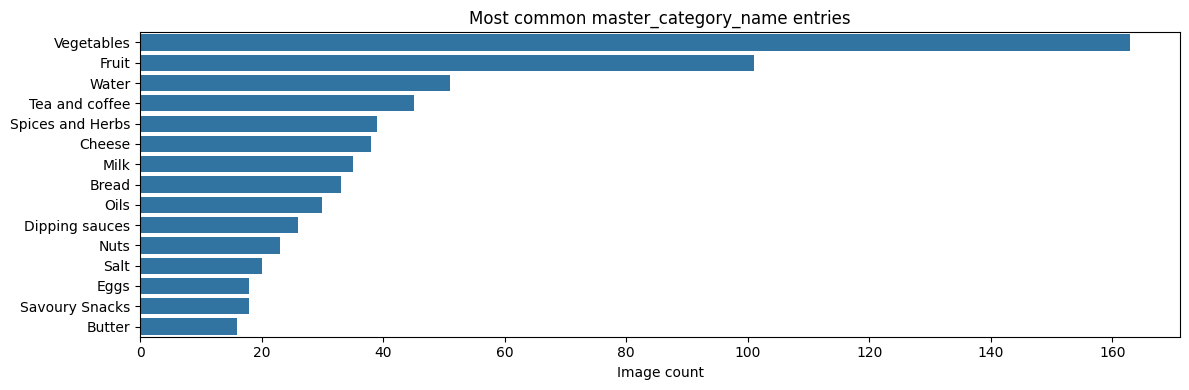

In [13]:
# Plot count of top 15 master_category_name values
plt.figure(figsize=(12,4))
order = df["master_category_name"].value_counts().index[:15]
sns.countplot(data=df, y="master_category_name", order=order)
plt.title("Most common master_category_name entries")
plt.xlabel("Image count")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [17]:
# Define Google Cloud Storage bucket and filesystem
BUCKET = "mealrecognition-dataset-images"  
fs = fsspec.filesystem("gcs")               

# Quick test: list the first 5 objects in the bucket root
for path in fs.ls(BUCKET)[:5]:
    print(path)

mealrecognition-dataset-images/CROWDSOURCED_PHOTOS
mealrecognition-dataset-images/EVAL_PHOTOS
mealrecognition-dataset-images/GOLD_PHOTOS
mealrecognition-dataset-images/GRANULARITY
mealrecognition-dataset-images/LOGGED_MEALS


In [18]:
PREFIX = "EVAL_PHOTOS/GB"     

paths = fs.ls(f"{BUCKET}/{PREFIX}", detail=False)
print(f"Found {len(paths):,} objects under gs://{BUCKET}/{PREFIX}")
for p in paths[:10]:
    print("  •", p.split("/")[-1])

Found 5,000 objects under gs://mealrecognition-dataset-images/EVAL_PHOTOS/GB
  • 000f560b-6103-455c-b50f-7ebb64956053.jpg
  • 001e5fe5-f5d5-4926-8355-c1d22aeebf82.jpg
  • 0041bfb6-af78-4704-bf6e-7b531b63fa74.jpg
  • 0044ef9c-d224-4b7d-8bbe-6f10f9d24a37.jpg
  • 00465d7d-0bb8-4a60-ab46-0d9ad34a0738.jpg
  • 00506148-96aa-4979-9b06-93912bb836ce.jpg
  • 005b63c5-53ec-4443-9b16-eec59eb35463.jpg
  • 00664322-6725-4178-ad6d-b598bea55ce4.jpg
  • 006e307c-25d1-4f41-b197-2f23dcfbcb85.jpg
  • 008ce865-075b-4e25-aa67-a99400362493.jpg


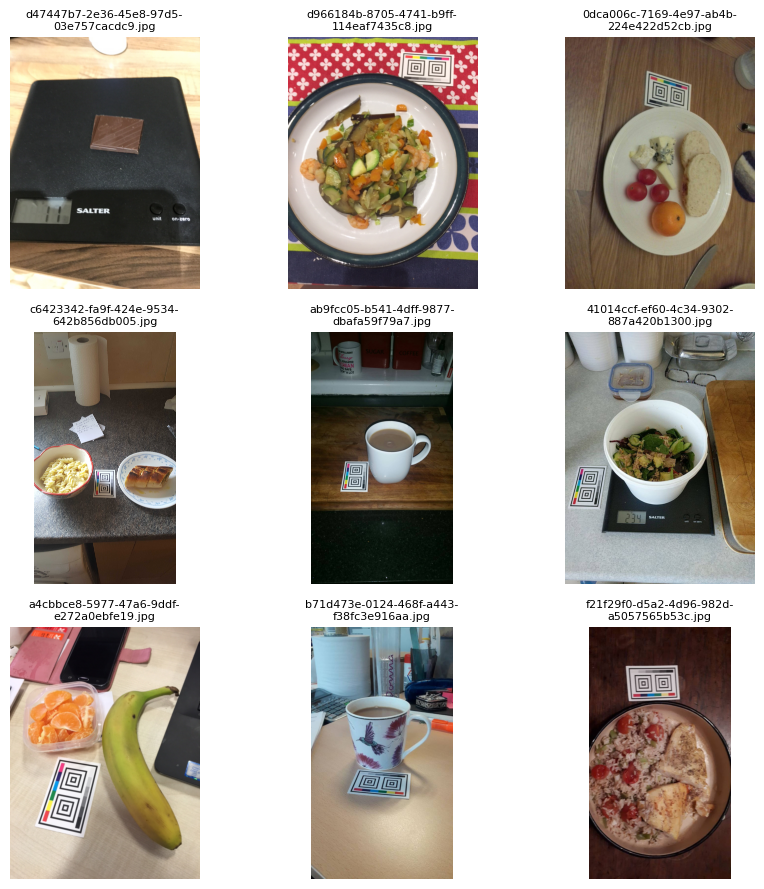

In [19]:
def open_remote_image(gcs_path):
    """Return a PIL Image read directly from GCS into memory."""
    with fs.open(gcs_path, "rb") as f:
        return Image.open(BytesIO(f.read()))

SAMPLE = random.sample(paths, k=9)       

fig, axes = plt.subplots(3, 3, figsize=(9,9))
for ax, gcs_path in zip(axes.flatten(), SAMPLE):
    img = open_remote_image(gcs_path)
    ax.imshow(img)
    ax.set_title(textwrap.fill(gcs_path.split('/')[-1], 25), fontsize=8)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Dowload and Link Relevant Images

In [28]:
DEST_ROOT = Path("/home/jupyter/images")        

fs = gcsfs.GCSFileSystem()

In [29]:
# Compute set of unique image filenames needed
needed = set(df["image_filename"].unique())
print(f"Need {len(needed):,} unique images")

Need 919 unique images


In [30]:
# Build a mapping from basename to full GCS path
found = {}             # basename.jpg  ->  full gs:// path

for blob in tqdm(fs.find(f"{BUCKET}"), desc="Scanning bucket"):
    name = blob.rsplit("/", 1)[-1]               # basename
    if name in needed and name not in found:
        found[name] = blob
        if len(found) == len(needed):
            break    #  all located, stop early

print(f"Matched {len(found)}/{len(needed)} files")

Scanning bucket:  78%|███████▊  | 10506/13430 [00:00<00:00, 1223052.48it/s]

Matched 919/919 files


In [31]:
DEST_ROOT.mkdir(parents=True, exist_ok=True)

# Download each matched image locally (skip if already exists)
for name, gcs_path in tqdm(found.items(), desc="Downloading", unit="file"):
    local_path = DEST_ROOT / name
    if not local_path.exists():                  
        fs.get(gcs_path, local_path.as_posix())

Downloading: 100%|██████████| 919/919 [01:08<00:00, 13.49file/s]


In [32]:
# Map local filesystem paths back to dataframe
def local_path_from_filename(fname):
    """
    Return the local filesystem path for a given filename if it exists.
    Otherwise, return pandas.NA.
    """
    p = DEST_ROOT / fname
    return p if p.exists() else pd.NA

df["local_path"] = df["image_filename"].map(local_path_from_filename).astype("string")

coverage = df["local_path"].notna().mean()
print(f"Local image coverage: {coverage:.2%}")


Local image coverage: 100.00%


In [33]:
df.to_parquet("meal_metadata_with_paths.parquet", index=False)

# Experiments

## Baseline - CLIP ViT-B-32

In [30]:
df = pd.read_parquet("meal_metadata_with_paths.parquet")

# ensure timestamp is datetime
df["created_at"] = pd.to_datetime(df["created_at"])
cutoff = df["created_at"].quantile(0.85)        # last 15 % = test

df["split"] = "train"
df.loc[df["created_at"] >= cutoff, "split"] = "test"

# quick tally
print(df["split"].value_counts())
df.to_parquet("meal_metadata_with_split.parquet", index=False)

split
train    849
test     151
Name: count, dtype: int64


In [3]:
# CLIP normalization constants for ViT-B-32
CLIP_MEAN = (0.48145466, 0.4578275 , 0.40821073)
CLIP_STD  = (0.26862954, 0.26130258, 0.27577711)

# Compose image transforms: resize, center-crop, to tensor, normalize
preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(CLIP_MEAN, CLIP_STD),
])

class MealDataset(Dataset):
    """
    PyTorch Dataset for meal images and metadata.
    Returns preprocessed images and their corresponding row index.
    """
    def __init__(self, dataframe, transform):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing at least 'local_path'.
            transform (transforms.Compose): Preprocessing pipeline to apply to each image.
        """
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
         """
        Load and preprocess the image at the given index.
        
        Args:
            idx (int): Index of the row in the DataFrame.
        
        Returns:
            tuple(torch.Tensor, int): Transformed image tensor and the original index.
        """
        row = self.df.iloc[idx]
        img = Image.open(row["local_path"]).convert("RGB")
        return self.transform(img), idx          # idx lets us map back later

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create CLIP model and transforms (ViT-B-32 pretrained on OpenAI)
model, _, preprocess_clip = open_clip.create_model_and_transforms(
    model_name="ViT-B-32",
    pretrained="openai",
    device=device,
)
model.eval()


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/opt/conda/envs/pytorch/lib/python3.10/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0): ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
        (1): ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, 

In [7]:
# Create PyTorch DataLoader for all images (no shuffling to maintain index mapping)
BATCH = 64

ds = MealDataset(df, preprocess)
loader = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=4)

# Preallocate array for embeddings
embeddings = np.empty((len(df), model.visual.output_dim), dtype="float32")

# Compute embeddings in batches (L2-normalized)
with torch.no_grad():
    for imgs, idxs in tqdm(loader, total=math.ceil(len(ds)/BATCH)):
        imgs = imgs.to(device)
        feats = model.encode_image(imgs).float()
        feats /= feats.norm(dim=-1, keepdim=True)      # L2-normalise
        embeddings[idxs.numpy()] = feats.cpu().numpy()

# Save embeddings to disk
np.save("clip_vitb32_embeddings.npy", embeddings)
print("Saved embeddings:", embeddings.shape)

100%|██████████| 16/16 [01:30<00:00,  5.68s/it]

Saved embeddings: (1000, 512)


In [8]:
# Dimension of each vector
d = embeddings.shape[1]
index = faiss.IndexFlatIP(d)          # inner-product == cosine on unit vectors
index.add(embeddings)                 # ids == row indices in df
faiss.write_index(index, "clip_ip.index")
print("Index size:", index.ntotal)

Index size: 1000


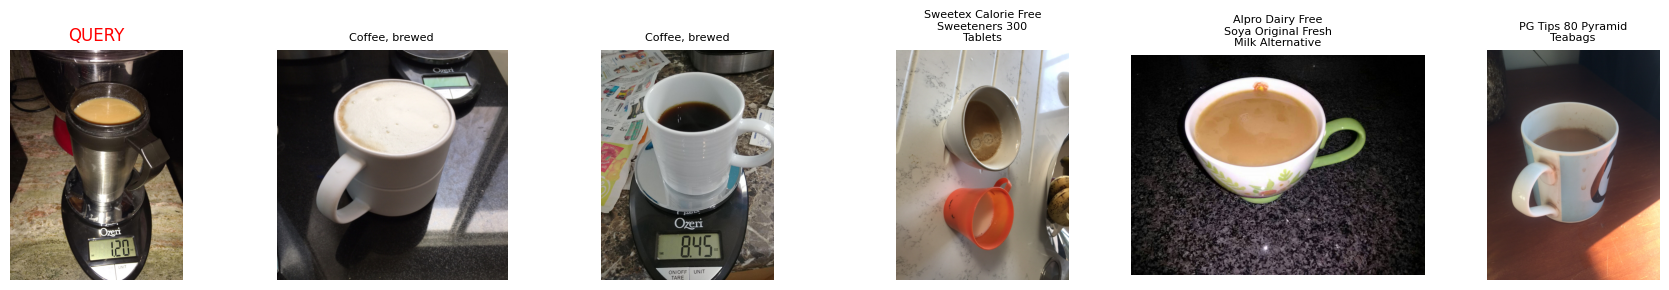

In [9]:
def show_retrieval(query_idx, k=5):
    """
    Display the query image and top-k nearest neighbors based on cosine similarity.
    
    Args:
        query_idx (int): Index of the query image in the DataFrame.
        k (int): Number of neighbors to display (excluding the query itself).
    """
    q_vec = embeddings[query_idx:query_idx+1]
    D, I = index.search(q_vec, k+1)    # +1 because first hit is itself
    hits = I[0,1:]                     # discard self-match

    # plot
    fig, axes = plt.subplots(1, k+1, figsize=(3*(k+1), 3))
    # leftmost = query
    q_img = Image.open(df.loc[query_idx, "local_path"])
    axes[0].imshow(q_img); axes[0].set_title("QUERY", color="red"); axes[0].axis("off")

    for ax, hit in zip(axes[1:], hits):
        img = Image.open(df.loc[hit, "local_path"])
        title = textwrap.fill(df.loc[hit, "food_name"], 20)
        ax.imshow(img); ax.set_title(title, fontsize=8); ax.axis("off")
    plt.tight_layout(); plt.show()

show_retrieval(random.randint(0, len(df)-1))

### Pseudo metric

In [15]:
def recall_at_k(k=10, n_queries=200):
    """
    Compute the pseudo-Recall@k metric: percentage of queries for which
    at least one of the top-k retrieved images shares the same 'food_id'.
    
    Args:
        k (int): Number of nearest neighbors to consider.
        n_queries (int): Number of random queries to sample.
    
    Returns:
        float: Pseudo-Recall@k (between 0 and 1).
    """
    ok, total = 0, 0
    for q in random.sample(range(len(df)), n_queries):
        q_vec = embeddings[q:q+1]
        D, I = index.search(q_vec, k+1)
        hits = I[0,1:]         # exclude self
        total += 1
        if any(df.loc[h, "food_id"] == df.loc[q, "food_id"] for h in hits):
            ok += 1
    return ok/total

print(f"Pseudo-Recall@10: {recall_at_k(10, n_queries=200):.1%}")

Pseudo-Recall@10: 13.5%


In [16]:
meta = {
    "model": "open_clip ViT-B-32",
    "norm": "L2",
    "index_type": "IndexFlatIP",
    "rows": len(df),
}
with open("index_meta.json", "w") as f: json.dump(meta, f, indent=2)

### Actual Metrics

#### Definition A – strict match on food_id

In [51]:

def make_pos_sets_by_index(df: pd.DataFrame, label_col: str) -> dict[int, list[int]]:
    """
    Return {row_index: list_of_positive_row_indices}.
    """
    pos_sets = {}
    for _, grp in df.groupby(label_col):
        idxs = grp.index.tolist()
        if len(idxs) < 2:          # singletons give no positives; skip
            continue
        for idx in idxs:
            pos_sets[idx] = [i for i in idxs if i != idx]   # exclude self
    return pos_sets

# Choose your label granularity:
pos_by_query = make_pos_sets_by_index(df, label_col="food_id")           # strict

In [52]:
coverage = sum(1 for i in df.index if i in pos_by_query) / len(df)
print(f"Queries with ≥1 positive: {coverage:.1%}")

Queries with ≥1 positive: 36.5%


#### Definition B – coarse match on country name and parent name

In [45]:
def make_pos_sets_by_index(df: pd.DataFrame, label_col: str) -> dict[int, list[int]]:
    pos_sets = {}
    for _, grp in df.groupby(label_col):
        idxs = grp.index.tolist()
        if len(idxs) < 2:          # singletons give no positives; skip
            continue
        for idx in idxs:
            pos_sets[idx] = [i for i in idxs if i != idx]
    return pos_sets

df["label_coarse"] = df["parent_name"] + "_" + df["country"]   # ← 1-liner key
pos_by_query = make_pos_sets_by_index(df, "label_coarse")

coverage = sum(i in pos_by_query for i in df.index) / len(df)
print(f"Queries with ≥1 positive (coarse): {coverage:.1%}")

Queries with ≥1 positive (coarse): 82.1%


In [53]:
def recall_at_k(query_vecs: np.ndarray,
                query_idxs: List[int],
                k: int,
                pos_sets: Dict[int, List[int]]) -> float:
    D, I = index.search(query_vecs, k + 1)          # k+1 incl. self
    hits = 0
    for row, q_idx in enumerate(query_idxs):
        positives = set(pos_sets.get(q_idx, [])) - {q_idx}
        if not positives:
            continue
        retrieved = set(I[row, 1:])                 # drop self
        if retrieved & positives:
            hits += 1
    return hits / len(query_idxs)

def average_precision(hit_ranks: List[int], k: int) -> float:
    if not hit_ranks:
        return 0.0
    hit_ranks = sorted(r for r in hit_ranks if r < k)
    precisions = [(i + 1) / (r + 1) for i, r in enumerate(hit_ranks)]
    return sum(precisions) / min(len(hit_ranks), k)

def map_at_k(query_vecs: np.ndarray,
             query_idxs: List[int],
             k: int,
             pos_sets: Dict[int, List[int]]) -> float:
    D, I = index.search(query_vecs, k + 1)
    aps = []
    for row, q_idx in enumerate(query_idxs):
        positives = set(pos_sets.get(q_idx, [])) - {q_idx}
        if not positives:
            continue
        ranks = [r for r, img_idx in enumerate(I[row, 1:], start=0)
                 if img_idx in positives]
        aps.append(average_precision(ranks, k))
    return np.mean(aps) if aps else 0.0

def ndcg_calorie(query_idxs: List[int], k: int, sigma: float = 50.) -> float:
    D, I = index.search(embeddings[query_idxs], k + 1)
    scores = []
    for row, q_idx in enumerate(query_idxs):
        q_cals = float(df.loc[q_idx, "calories"] or 0)
        gains = []
        for rank, img_idx in enumerate(I[row, 1:], start=1):
            delta = abs(float(df.loc[img_idx, "calories"] or 0) - q_cals)
            gain  = math.exp(-delta / sigma)
            gains.append(gain / math.log2(rank + 1))
        ideal = [1.0 / math.log2(r + 1) for r in range(1, k + 1)]
        scores.append(sum(gains) / sum(ideal))
    return np.mean(scores)


In [54]:
def bootstrap_metric(metric_fn, n_iters=1_000, **kwargs):
    rng = np.random.default_rng(42)
    scores = []
    for _ in range(n_iters):
        sample = rng.choice(kwargs["query_idxs"], size=len(kwargs["query_idxs"]), replace=True)
        score = metric_fn(query_idxs=sample, **{k:v for k,v in kwargs.items()
                                                if k != "query_idxs"})
        scores.append(score)
    scores = np.asarray(scores)
    low, high = np.percentile(scores, [2.5, 97.5]).astype(float)
    return float(scores.mean()), (low, high)      # ← mean of bootstrap, not full-set call

In [55]:
TEST_IDXS = df.index[df["split"] == "test"].tolist()
random.shuffle(TEST_IDXS)                      # so bootstrap has variety

# Vector slice once for efficiency
TEST_EMBS  = embeddings[TEST_IDXS]

results = {}

for k in [1, 5, 10]:
    rec, ci = bootstrap_metric(
        recall_at_k, query_vecs=TEST_EMBS, query_idxs=TEST_IDXS,
        k=k, pos_sets=pos_by_query, n_iters=500)
    results[f"Recall@{k:02d}"] = f"{rec:.3f}  [{ci[0]:.3f},{ci[1]:.3f}]"

mAP, ci = bootstrap_metric(
        map_at_k, query_vecs=TEST_EMBS, query_idxs=TEST_IDXS,
        k=100, pos_sets=pos_by_query, n_iters=500)
results["mAP@100"] = f"{mAP:.3f}  [{ci[0]:.3f},{ci[1]:.3f}]"

nDCG, ci = bootstrap_metric(
        ndcg_calorie, query_idxs=TEST_IDXS,
        k=10, n_iters=500)
results["nDCG@10"] = f"{nDCG:.3f}  [{ci[0]:.3f},{ci[1]:.3f}]"

from pprint import pprint
pprint(results)

{'Recall@01': '0.001  [0.000,0.007]',
 'Recall@05': '0.005  [0.000,0.020]',
 'Recall@10': '0.009  [0.000,0.026]',
 'mAP@100': '0.013  [0.003,0.035]',
 'nDCG@10': '0.398  [0.362,0.434]'}


### Visual Inspection

Saved figures/panel_q44.png


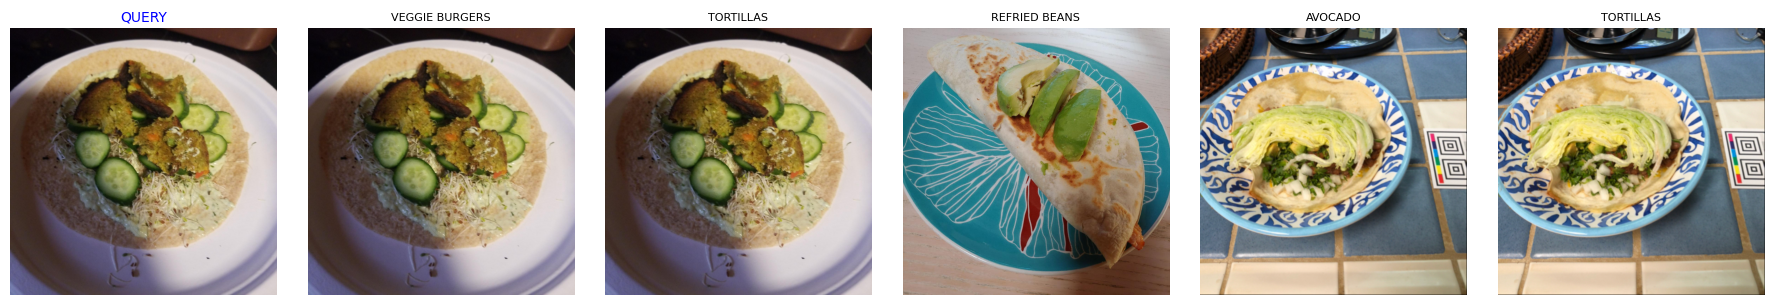

In [56]:
FIG_DIR = Path("figures"); FIG_DIR.mkdir(exist_ok=True)

def show_retrieval_panel(query_idx: int,
                         k: int = 5,
                         pos_sets: dict[int, list[int]] = pos_by_query,
                         save: bool = True):
    """
    Draws a (k+1)-wide panel:   | QUERY | hit1 | hit2 | ... |
    Red border = incorrect under pos_sets.
    """
    q_vec = embeddings[query_idx : query_idx + 1]
    D, I = index.search(q_vec, k + 1)        # first is the query itself
    hit_indices = I[0, 1:]

    # Prep the figure
    fig, axes = plt.subplots(1, k + 1, figsize=(3 * (k + 1), 3))
    axes = axes.flatten()

    #the query
    q_img = Image.open(df.loc[query_idx, "local_path"])
    axes[0].imshow(q_img)
    axes[0].set_title("QUERY", color="blue", fontsize=10)
    axes[0].axis("off")

    #the retrieved neighbours 
    positives = set(pos_sets.get(query_idx, []))
    for ax, hit_idx in zip(axes[1:], hit_indices):
        img = Image.open(df.loc[hit_idx, "local_path"])
        ax.imshow(img)

        label = textwrap.fill(df.loc[hit_idx, "parent_name"], 20)
        ax.set_title(label, fontsize=8)

        # Red border if not a positive
        if hit_idx not in positives:
            for spine in ax.spines.values():
                spine.set_edgecolor("red"); spine.set_linewidth(3)
        ax.axis("off")

    plt.tight_layout()
    if save:
        out_path = FIG_DIR / f"panel_q{query_idx}.png"
        plt.savefig(out_path, dpi=150)
        print("Saved", out_path)
    plt.show()


random_query = random.choice(TEST_IDXS)
show_retrieval_panel(random_query, k=5)